#Prediction and Visualization of Ambient Air Quality using deep learning models

*Primary source of data are official reporting from countries to WHO, official national/subnational reports and nations/subnational web sites containing measurements of **PM10** or **PM2.5** *


> What is the Difference Between **PM10** and **PM2.5**?

* Emissions from combustion of gasoline, oil, diesel fuel or wood produce much of the PM2.5 pollution found in outdoor air, as well as a significant proportion of PM10. 

* PM10 also includes dust from construction sites, landfills and agriculture, wildfires and brush/waste burning, industrial sources, wind-blown dust from open lands, pollen and fragments of bacteria.

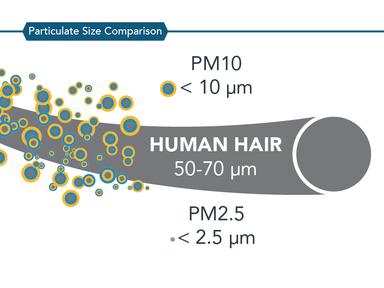

# Importing required modules

In [ ]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image

from collections.abc import Sequence
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import figure, show
import pandas as pd
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from keras.optimizers import Adam

import math as Math



# Initializing helper functions

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,title,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.title(title)
    plt.legend()
    plt.show()

def cnn_to_sequences(seq_size, data, target):
    x = []
    y = []

    print(len(data)-SEQUENCE_SIZE-1)
    for i in range(len(data)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        window = [x for x in window]
        x.append([window])
        y.append(target[i+SEQUENCE_SIZE])
        
    return np.array(x),np.array(y)

# Formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def to_sequences(seq_size, x_data, y_data):
    x = []
    y = []

    for i in range(len(x_data)-SEQUENCE_SIZE-1):
        window = x_data[i:(i+SEQUENCE_SIZE)]
        after_window = y_data[i+seq_size]
        window = [x for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
import numpy as np

def lstm_to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data pre-processing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WHO.csv',encoding='utf8', na_values=['NA','?'])

In [ ]:
df.head()

,ID WHO city,iso3,country,city,pm10,Year,type_of_stations,pm10_type,pm25,pm25_type,reference,latitude,longitude,population,wbinc16_text,region,date_compiled,population_source,tempcov_PM10,tempcov_PM25,latitude_pop,longitude_pop,Region,region_abbr,tempcov_PM10_grad,tempcov_PM25_grad,conc_pm25,color_pm25,conc_pm10,color_pm10
0,3.0,ALB,Albania,Tirana,31.615421,2013,"1 station, traffic, urban",Measured,16.062366,Measured,"European Environment Agency, Air quality e-rep...",41.330269,19.821772,453509.0,Upper middle income,Eur_LM,2016,NaN,NaN,NaN,NaN,NaN,Europe (LMIC),Eur (LMIC),NaN,NaN,15-<25,orange,30-<50,darkred
1,15.0,AUS,Australia,Central Coast,12.820462,2014,-,Converted,5.500000,Measured,http://www.environment.nsw.gov.au/resources/aq...,-33.278889,151.432495,297713.0,High income,Wpr_HI,2016,NaN,NaN,NaN,NaN,NaN,Western Pacific (HIC),Wpr (HIC),NaN,NaN,<10,green,<20,green
2,18.0,AUS,Australia,Devonport,14.918356,2013,-,Converted,6.400000,Measured,Environment Protection Authority,-41.184799,146.345993,29050.0,High income,Wpr_HI,2016,NaN,NaN,NaN,NaN,NaN,Western Pacific (HIC),Wpr (HIC),NaN,NaN,<10,green,<20,green
3,19.0,AUS,Australia,Geelong,17.500000,2014,"1 station, Residential/Light Industry",Measured,7.507530,Converted,"EPA Victoria, Environment Protection Authority...",-38.174999,144.369003,173450.0,High income,Wpr_HI,2016,NaN,NaN,NaN,NaN,NaN,Western Pacific (HIC),Wpr (HIC),NaN,NaN,<10,green,<20,green
4,22.0,AUS,Australia,Hobart,14.219058,2013,-,Converted,6.100000,Measured,Environment Protection Authority,-42.854599,147.315002,170977.0,High income,Wpr_HI,2016,NaN,NaN,NaN,NaN,NaN,Western Pacific (HIC),Wpr (HIC),NaN,NaN,<10,green,<20,green


In [ ]:
df_updated=df.drop(columns=['ID WHO city',
                            'iso3','city','type_of_stations','reference','latitude',
                            'longitude','region','date_compiled','population_source',
                            'tempcov_PM10','tempcov_PM25','latitude_pop','longitude_pop','Region',
                            'region_abbr','tempcov_PM10_grad','tempcov_PM25_grad','conc_pm25','conc_pm10'], axis=1)

In [ ]:
df_updated

,country,pm10,Year,pm10_type,pm25,pm25_type,population,wbinc16_text,color_pm25,color_pm10
0,Albania,31.615421,2013,Measured,16.062366,Measured,453509.0,Upper middle income,orange,darkred
1,Australia,12.820462,2014,Converted,5.500000,Measured,297713.0,High income,green,green
2,Australia,14.918356,2013,Converted,6.400000,Measured,29050.0,High income,green,green
3,Australia,17.500000,2014,Measured,7.507530,Converted,173450.0,High income,green,green
4,Australia,14.219058,2013,Converted,6.100000,Measured,170977.0,High income,green,green
...,...,...,...,...,...,...,...,...,...,...
11966,Saudi Arabia,201.000000,2014,Measured,51.000000,Measured,6369710.0,High income,darkred,darkred
11967,Saudi Arabia,240.000000,2015,Measured,69.000000,Measured,6369710.0,High income,darkred,darkred
11968,Saudi Arabia,251.000000,2016,Measured,73.000000,Measured,6369710.0,High income,darkred,darkred
11969,Saudi Arabia,260.000000,2015,Measured,61.000000,Measured,1073788.0,High income,darkred,darkred


In [ ]:
df_updated_copy = df_updated.copy()

# Copying all the features to col_names Variable
col_names = df_updated_copy.head(0)


In [ ]:
# One hot encoding categorical features
cat_cols = ['country','pm10_type','pm25_type','wbinc16_text','color_pm25','color_pm10']

for i in cat_cols:
  encode_text_dummy(df_updated_copy,i)

df_updated_copy

,pm10,Year,pm25,population,country-Albania,country-Andorra,country-Argentina,country-Australia,country-Austria,country-Bahrain,country-Bangladesh,country-Belarus,country-Belgium,country-Bhutan,"country-Bolivia, Plurinational States of",country-Bosnia and Herzegovina,country-Brazil,country-Bulgaria,country-Cameroon,country-Canada,country-Chile,country-China,country-Colombia,country-Costa Rica,country-Croatia,country-Cuba,country-Cyprus,country-Czechia,country-Denmark,country-Ecuador,country-Egypt,country-El Salvador,country-Estonia,country-Fiji,country-Finland,country-France,country-Georgia,country-Germany,country-Ghana,country-Greece,...,country-South Africa,country-Spain,country-Sri Lanka,country-Sweden,country-Switzerland,country-Thailand,country-The former Yugoslav Republic of Macedonia,country-Tunisia,country-Turkey,country-Uganda,country-Ukraine,country-United Arab Emirates,country-United Kingdom,country-United Republic of Tanzania,country-United States of America,country-Uruguay,"country-Venezuela, Bolivarian Republic of",country-Viet Nam,pm10_type-Converted,pm10_type-Measured,pm10_type-measured,pm25_type-Converted,pm25_type-Measured,pm25_type-converted,pm25_type-measured,wbinc16_text-High income,wbinc16_text-Low income,wbinc16_text-Lower middle income,wbinc16_text-Upper middle income,color_pm25-darkorange,color_pm25-darkred,color_pm25-green,color_pm25-orange,color_pm25-red,color_pm25-yellow,color_pm10-darkred,color_pm10-green,color_pm10-orange,color_pm10-red,color_pm10-yellow
0,31.615421,2013,16.062366,453509.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,12.820462,2014,5.500000,297713.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,14.918356,2013,6.400000,29050.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,17.500000,2014,7.507530,173450.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,14.219058,2013,6.100000,170977.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11966,201.000000,2014,51.000000,6369710.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
11967,240.000000,2015,69.000000,6369710.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
11968,251.000000,2016,73.000000,6369710.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
11969,260.000000,2015,61.000000,1073788.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
# Normalizing numerical features 

num_cols = ['pm10','pm25','population','Year']

for i in num_cols:
  encode_numeric_zscore(df_updated_copy,i)

df_updated_copy

,pm10,Year,pm25,population,country-Albania,country-Andorra,country-Argentina,country-Australia,country-Austria,country-Bahrain,country-Bangladesh,country-Belarus,country-Belgium,country-Bhutan,"country-Bolivia, Plurinational States of",country-Bosnia and Herzegovina,country-Brazil,country-Bulgaria,country-Cameroon,country-Canada,country-Chile,country-China,country-Colombia,country-Costa Rica,country-Croatia,country-Cuba,country-Cyprus,country-Czechia,country-Denmark,country-Ecuador,country-Egypt,country-El Salvador,country-Estonia,country-Fiji,country-Finland,country-France,country-Georgia,country-Germany,country-Ghana,country-Greece,...,country-South Africa,country-Spain,country-Sri Lanka,country-Sweden,country-Switzerland,country-Thailand,country-The former Yugoslav Republic of Macedonia,country-Tunisia,country-Turkey,country-Uganda,country-Ukraine,country-United Arab Emirates,country-United Kingdom,country-United Republic of Tanzania,country-United States of America,country-Uruguay,"country-Venezuela, Bolivarian Republic of",country-Viet Nam,pm10_type-Converted,pm10_type-Measured,pm10_type-measured,pm25_type-Converted,pm25_type-Measured,pm25_type-converted,pm25_type-measured,wbinc16_text-High income,wbinc16_text-Low income,wbinc16_text-Lower middle income,wbinc16_text-Upper middle income,color_pm25-darkorange,color_pm25-darkred,color_pm25-green,color_pm25-orange,color_pm25-red,color_pm25-yellow,color_pm10-darkred,color_pm10-green,color_pm10-orange,color_pm10-red,color_pm10-yellow
0,0.025926,-0.956987,-0.127463,0.010239,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,-0.596256,-0.237428,-0.802649,-0.080583,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,-0.526808,-0.956987,-0.745118,-0.237201,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,-0.441346,-0.237428,-0.674321,-0.153022,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,-0.549958,-0.956987,-0.764295,-0.154464,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11966,5.633184,-0.237428,2.105881,3.459110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
11967,6.924229,0.482130,3.256508,3.459110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
11968,7.288370,1.201688,3.512203,3.459110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
11969,7.586303,0.482130,2.745118,0.371833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
# Splitting data to x and y to train the models
x,y = to_xy(df_updated_copy,"pm10")
x1,y1 = to_xy(df_updated_copy,"pm25")

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
x_train1,x_test1,y_train1,y_test1=train_test_split(x1,y1,test_size=0.3,random_state=42)

# Using FCNN full-connected neural network model

In [ ]:
print('Build model...')
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))# Hidden 1
model.add(Dense(50, activation='relu'))# Hidden 2
model.add(Dropout(0.1)) #Dropout layer
model.add(Dense(25, activation='relu')) # Hidden 3
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')  
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)

Build model...


In [ ]:
for i in range(3):
    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=300)  
    model.load_weights('best_weights.hdf5')
    
    #Predict
    pred = model.predict(x_test)
    

for i in range(3):
    model.fit(x_train1, y_train1, validation_data=(x_test1,y_test1), callbacks=[monitor, checkpointer], verbose=1, epochs=300)  
    model.load_weights('best_weights.hdf5')
    
    #Predict
    pred1 = model.predict(x_test1)



Epoch 1/300
262/262 [==============================] - 2s 4ms/step - loss: 0.3250 - val_loss: 0.0979
Epoch 2/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0625 - val_loss: 0.1007
Epoch 3/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0398 - val_loss: 0.0735
Epoch 4/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0370 - val_loss: 0.0778
Epoch 5/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0367 - val_loss: 0.0654
Epoch 6/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0642
Epoch 7/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0732
Epoch 8/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0375 - val_loss: 0.0651
Epoch 9/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0606
Epoch 10/300
262/262 [==============================] - 1s 2ms/step - loss: 0.0240 - val_lo

In [ ]:
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE) for pm10: {}".format(score))

# Measure RMSE error.
score1 = np.sqrt(metrics.mean_squared_error(pred1,y_test1))
print("Score (RMSE) for pm25: {}".format(score1))

Score (RMSE) for pm10: 0.2240353524684906
Score (RMSE) for pm25: 0.17741015553474426


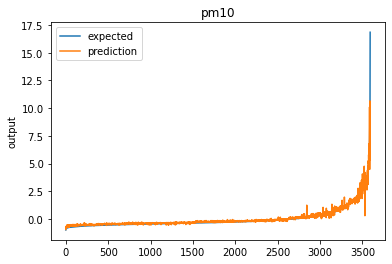

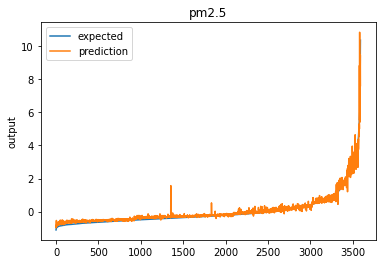

In [ ]:
#Regression Lift Chart
# Plot the chart
chart_regression(pred.flatten(),y_test, "pm10",sort=True)
print()
chart_regression(pred1.flatten(),y_test1, "pm2.5",sort=True)

#FCNN Parameter Tuning - using a 'sigmoid' as activation and 'sgd' as optimizer

In [ ]:
print('Build model...')
model = Sequential()
model.add(Dense(120, input_dim=x.shape[1], activation='sigmoid'))# Hidden 1
model.add(Dense(70, activation='sigmoid'))# Hidden 2
model.add(Dropout(0.2)) #Dropout layer
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(25, activation='sigmoid'))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='sgd')  
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights1.hdf5", verbose=0, save_best_only=True)

Build model...


In [ ]:
for i in range(3):
    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=300)  
    model.load_weights('best_weights1.hdf5')
    
    #Predict
    pred = model.predict(x_test)
    


for i in range(3):
    model.fit(x_train1, y_train1, validation_data=(x_test1,y_test1), callbacks=[monitor, checkpointer], verbose=1, epochs=300)  
    model.load_weights('best_weights1.hdf5')
    
    #Predict
    pred1 = model.predict(x_test1)


Epoch 1/300
262/262 [==============================] - 1s 2ms/step - loss: 1.0009 - val_loss: 0.9703
Epoch 2/300
262/262 [==============================] - 0s 2ms/step - loss: 0.9038 - val_loss: 0.9741
Epoch 3/300
262/262 [==============================] - 0s 2ms/step - loss: 1.0360 - val_loss: 0.9722
Epoch 4/300
262/262 [==============================] - 1s 2ms/step - loss: 1.0197 - val_loss: 0.9668
Epoch 5/300
262/262 [==============================] - 0s 2ms/step - loss: 1.0952 - val_loss: 0.9824
Epoch 6/300
262/262 [==============================] - 0s 2ms/step - loss: 1.0487 - val_loss: 0.9635
Epoch 7/300
262/262 [==============================] - 0s 2ms/step - loss: 1.0095 - val_loss: 0.9619
Epoch 8/300
262/262 [==============================] - 0s 2ms/step - loss: 1.0239 - val_loss: 0.9657
Epoch 9/300
262/262 [==============================] - 0s 2ms/step - loss: 0.9796 - val_loss: 0.9609
Epoch 10/300
262/262 [==============================] - 0s 2ms/step - loss: 0.9616 - val_lo

In [ ]:
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE) for pm10: {}".format(score))

# Measure RMSE error.
score1 = np.sqrt(metrics.mean_squared_error(pred1,y_test1))
print("Score (RMSE) for pm25: {}".format(score1))

Score (RMSE) for pm10: 0.2768693268299103
Score (RMSE) for pm25: 0.2183002084493637


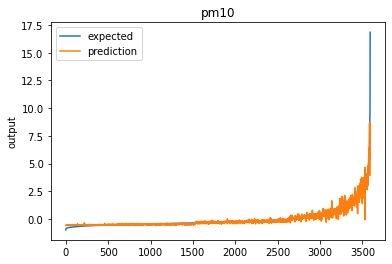

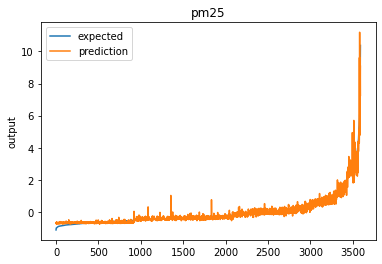

In [ ]:
#Regression Lift Chart
# Plot the chart
chart_regression(pred.flatten(),y_test,"pm10", sort=True)
print()
chart_regression(pred1.flatten(),y_test1,"pm25", sort=True)

#FCNN Parameter Tuning using 'tanh' as activation and 'adam' as optimizer

In [ ]:
print('Build model...')
model = Sequential()
model.add(Dense(200, input_dim=x.shape[1], activation='tanh'))# Hidden 1
model.add(Dense(175, activation='tanh'))# Hidden 2
model.add(Dropout(0.5)) #Dropout layer
model.add(Dense(120, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam') 
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights2.hdf5", verbose=0, save_best_only=True)

Build model...


In [ ]:
for i in range(3):
    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=300)  
    model.load_weights('best_weights2.hdf5')
    
    #Predict
    pred = model.predict(x_test)

for i in range(3):
    model.fit(x_train1, y_train1, validation_data=(x_test1,y_test1), callbacks=[monitor, checkpointer], verbose=1, epochs=300)  
    model.load_weights('best_weights2.hdf5')
    
    #Predict
    pred1 = model.predict(x_test1)
    
    

Epoch 1/300
262/262 [==============================] - 1s 3ms/step - loss: 0.2730 - val_loss: 0.1163
Epoch 2/300
262/262 [==============================] - 1s 3ms/step - loss: 0.1197 - val_loss: 0.0909
Epoch 3/300
262/262 [==============================] - 1s 3ms/step - loss: 0.0814 - val_loss: 0.0994
Epoch 4/300
262/262 [==============================] - 1s 3ms/step - loss: 0.0553 - val_loss: 0.0797
Epoch 5/300
262/262 [==============================] - 1s 3ms/step - loss: 0.0472 - val_loss: 0.0743
Epoch 6/300
262/262 [==============================] - 1s 3ms/step - loss: 0.0569 - val_loss: 0.0729
Epoch 7/300
262/262 [==============================] - 1s 3ms/step - loss: 0.0508 - val_loss: 0.0688
Epoch 8/300
262/262 [==============================] - 1s 3ms/step - loss: 0.0475 - val_loss: 0.0793
Epoch 9/300
262/262 [==============================] - 1s 3ms/step - loss: 0.0458 - val_loss: 0.0908
Epoch 10/300
262/262 [==============================] - 1s 3ms/step - loss: 0.0549 - val_lo

In [ ]:
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE) for pm10: {}".format(score))

score1 = np.sqrt(metrics.mean_squared_error(pred1,y_test1))
print("Score (RMSE) for pm25: {}".format(score1))

Score (RMSE) for pm10: 0.21186351776123047
Score (RMSE) for pm25: 0.15192200243473053


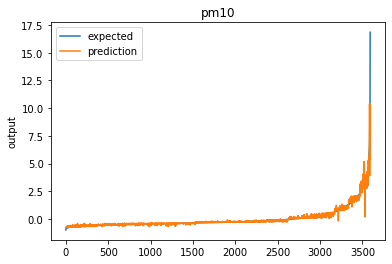

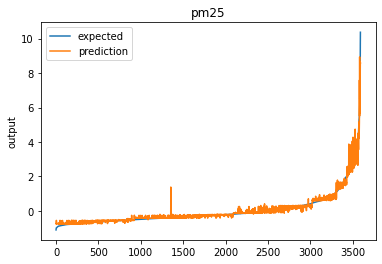

In [ ]:
#Regression Lift Chart
# Plot the chart
chart_regression(pred.flatten(),y_test, "pm10" ,sort=True)
print()
chart_regression(pred1.flatten(),y_test1, "pm25" ,sort=True)

# Using LSTM

In [ ]:
df_updated_copy1 = df_updated_copy.copy()

In [ ]:
train_set_size = df_updated_copy1.shape[0] * 0.70
train_set = Math.ceil(train_set_size)
df_train = df_updated_copy1[0:train_set]
df_test = df_updated_copy1[train_set+1 : df_updated_copy1.shape[0]]

pm10_train = df_train['pm10'].tolist()
pm10_test = df_test['pm10'].tolist()

pm25_train = df_train['pm25'].tolist()
pm25_test = df_test['pm25'].tolist()

print("Training set pm10 has {} records.".format(len(pm10_train)))
print("Test set pm10 has {} records.".format(len(pm10_test)))
print("Training set pm25 has {} records.".format(len(pm25_train)))
print("Test set pm25 has {} records.".format(len(pm25_test)))

Training set pm10 has 8380 records.
Test set pm10 has 3590 records.
Training set pm25 has 8380 records.
Test set pm25 has 3590 records.


In [ ]:
SEQUENCE_SIZE = 15
X_seq_train, Y_seq_train = lstm_to_sequences(SEQUENCE_SIZE,pm10_train)
X_seq_test,Y_seq_test = lstm_to_sequences(SEQUENCE_SIZE,pm10_test)

X_seq_train1, Y_seq_train1 = lstm_to_sequences(SEQUENCE_SIZE,pm25_train)
X_seq_test1,Y_seq_test1 = lstm_to_sequences(SEQUENCE_SIZE,pm25_test)


print("Shape of X_seq_train: {}".format(X_seq_train.shape))
print("Shape of Y_seq_train: {}".format(Y_seq_train.shape))
print("Shape of X_seq_test: {}".format(X_seq_test.shape))
print("Shape of Y_seq_test: {}".format(Y_seq_test.shape))

Shape of X_seq_train: (8364, 15, 1)
Shape of Y_seq_train: (8364,)
Shape of X_seq_test: (3574, 15, 1)
Shape of Y_seq_test: (3574,)


In [ ]:

print('Build model...')
model = Sequential()

model.add(LSTM(50, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 1)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weight3.hdf5", verbose=0, save_best_only=True)

Build model...


In [ ]:
for i in range(3):
    model.fit(X_seq_train,Y_seq_train,validation_data=(X_seq_test,Y_seq_test), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('best_weight3.hdf5')

    #Predict for pm10
    pred = model.predict(X_seq_test)

for i in range(3):
    model.fit(X_seq_train1,Y_seq_train1,validation_data=(X_seq_test1,Y_seq_test1), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('best_weight3.hdf5')

    #Predict for pm2.5
    pred1 = model.predict(X_seq_test1)
    


Epoch 1/300
262/262 - 6s - loss: 0.5531 - val_loss: 0.2032
Epoch 2/300
262/262 - 4s - loss: 0.4355 - val_loss: 0.1828
Epoch 3/300
262/262 - 4s - loss: 0.4252 - val_loss: 0.1809
Epoch 4/300
262/262 - 4s - loss: 0.4205 - val_loss: 0.1880
Epoch 5/300
262/262 - 4s - loss: 0.4203 - val_loss: 0.1826
Epoch 6/300
262/262 - 4s - loss: 0.4152 - val_loss: 0.1740
Epoch 7/300
262/262 - 4s - loss: 0.4103 - val_loss: 0.1761
Epoch 8/300
262/262 - 4s - loss: 0.4093 - val_loss: 0.1819
Epoch 9/300
262/262 - 4s - loss: 0.4033 - val_loss: 0.1720
Epoch 10/300
262/262 - 4s - loss: 0.4064 - val_loss: 0.1842
Epoch 11/300
262/262 - 4s - loss: 0.3978 - val_loss: 0.1657
Epoch 12/300
262/262 - 4s - loss: 0.3983 - val_loss: 0.1769
Epoch 13/300
262/262 - 4s - loss: 0.3997 - val_loss: 0.1734
Epoch 14/300
262/262 - 4s - loss: 0.4005 - val_loss: 0.1771
Epoch 15/300
262/262 - 4s - loss: 0.3992 - val_loss: 0.1709
Epoch 16/300
262/262 - 4s - loss: 0.3916 - val_loss: 0.1739
Epoch 00016: early stopping
Epoch 1/300
262/262 -

In [ ]:
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,Y_seq_test))
print("Score (RMSE): {}".format(score))

score1 = np.sqrt(metrics.mean_squared_error(pred1,Y_seq_test1))
print("Score (RMSE): {}".format(score1))

Score (RMSE): 0.4029775712898045
Score (RMSE): 0.44108947209052274


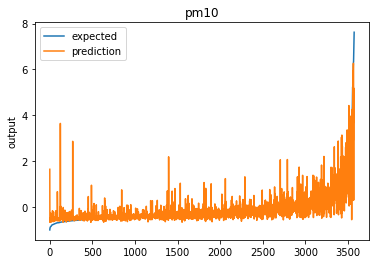

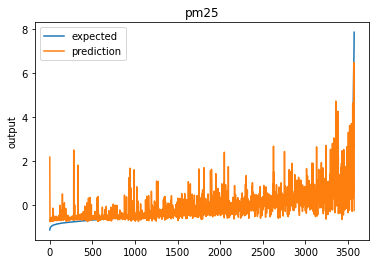

In [ ]:
#Regression Lift Chart
# Plot the chart
chart_regression(pred.flatten(),Y_seq_test, "pm10" ,sort=True)
print()
chart_regression(pred1.flatten(),Y_seq_test1, "pm25" ,sort=True)

 # LSTM Parameter Tuning 'sigmoid' as activation and 'sgd' as optimizer

In [ ]:

print('Build model...')
model = Sequential()

model.add(LSTM(60, dropout=0.2, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 1)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weight4.hdf5", verbose=0, save_best_only=True)

Build model...


In [ ]:
for i in range(3):
    model.fit(X_seq_train,Y_seq_train,validation_data=(X_seq_test,Y_seq_test), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('best_weight4.hdf5')

    #Predict
    pred = model.predict(X_seq_test)
    
for i in range(3):
    model.fit(X_seq_train1,Y_seq_train1,validation_data=(X_seq_test1,Y_seq_test1), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('best_weight4.hdf5')

    #Predict
    pred1 = model.predict(X_seq_test1)


Epoch 1/300
262/262 - 7s - loss: 0.8955 - val_loss: 0.3167
Epoch 2/300
262/262 - 4s - loss: 0.5717 - val_loss: 0.2773
Epoch 3/300
262/262 - 4s - loss: 0.5371 - val_loss: 0.2599
Epoch 4/300
262/262 - 4s - loss: 0.5235 - val_loss: 0.2496
Epoch 5/300
262/262 - 4s - loss: 0.5071 - val_loss: 0.2401
Epoch 6/300
262/262 - 4s - loss: 0.5007 - val_loss: 0.2328
Epoch 7/300
262/262 - 4s - loss: 0.5013 - val_loss: 0.2301
Epoch 8/300
262/262 - 4s - loss: 0.5044 - val_loss: 0.2253
Epoch 9/300
262/262 - 4s - loss: 0.4986 - val_loss: 0.2221
Epoch 10/300
262/262 - 4s - loss: 0.4825 - val_loss: 0.2220
Epoch 11/300
262/262 - 4s - loss: 0.4892 - val_loss: 0.2166
Epoch 12/300
262/262 - 4s - loss: 0.4816 - val_loss: 0.2146
Epoch 13/300
262/262 - 4s - loss: 0.4802 - val_loss: 0.2109
Epoch 14/300
262/262 - 4s - loss: 0.4800 - val_loss: 0.2119
Epoch 15/300
262/262 - 4s - loss: 0.4843 - val_loss: 0.2074
Epoch 16/300
262/262 - 4s - loss: 0.4776 - val_loss: 0.2088
Epoch 17/300
262/262 - 4s - loss: 0.4722 - val_lo

In [ ]:
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,Y_seq_test))
print("Score (RMSE) for pm10: {}".format(score))

score1 = np.sqrt(metrics.mean_squared_error(pred1,Y_seq_test1))
print("Score (RMSE) for pm25: {}".format(score1))

Score (RMSE) for pm10: 0.43246717854401356
Score (RMSE) for pm10: 0.455925853817485


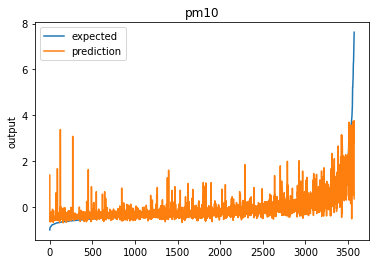

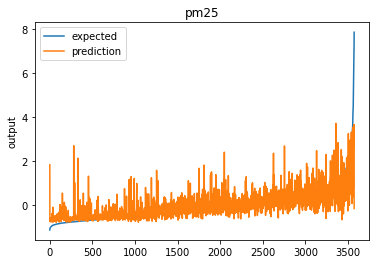

In [ ]:
#Regression Lift Chart
# Plot the chart
chart_regression(pred.flatten(),Y_seq_test, "pm10" ,sort=True)
print()
chart_regression(pred1.flatten(),Y_seq_test1, "pm25" ,sort=True)

#LSTM Parameter Tuning 'tanh' as activation and 'adam' as optimizer

In [ ]:

print('Build model...')
model = Sequential()

model.add(LSTM(125, dropout=0.2, recurrent_dropout=0.1,
               input_shape=(SEQUENCE_SIZE, 1)))
model.add(Dense(75, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(15, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weight5.hdf5", verbose=0, save_best_only=True)

Build model...


In [ ]:
for i in range(3):
    model.fit(X_seq_train,Y_seq_train,validation_data=(X_seq_test,Y_seq_test), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('best_weight5.hdf5')

    #Predict
    pred = model.predict(X_seq_test)

for i in range(3):
    model.fit(X_seq_train1,Y_seq_train1,validation_data=(X_seq_test1,Y_seq_test1), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('best_weight5.hdf5')

    #Predict
    pred1 = model.predict(X_seq_test1)
    
    

Epoch 1/300
262/262 - 11s - loss: 0.6657 - val_loss: 0.3250
Epoch 2/300
262/262 - 8s - loss: 0.6478 - val_loss: 0.3117
Epoch 3/300
262/262 - 8s - loss: 0.6496 - val_loss: 0.3142
Epoch 4/300
262/262 - 8s - loss: 0.6391 - val_loss: 0.3088
Epoch 5/300
262/262 - 8s - loss: 0.6376 - val_loss: 0.3173
Epoch 6/300
262/262 - 8s - loss: 0.6362 - val_loss: 0.3095
Epoch 7/300
262/262 - 8s - loss: 0.6347 - val_loss: 0.3095
Epoch 8/300
262/262 - 8s - loss: 0.6334 - val_loss: 0.3090
Epoch 9/300
262/262 - 8s - loss: 0.6353 - val_loss: 0.3087
Epoch 00009: early stopping
Epoch 1/300
262/262 - 8s - loss: 0.6326 - val_loss: 0.3097
Epoch 2/300
262/262 - 8s - loss: 0.6343 - val_loss: 0.3127
Epoch 3/300
262/262 - 8s - loss: 0.6320 - val_loss: 0.3087
Epoch 4/300
262/262 - 8s - loss: 0.6339 - val_loss: 0.3097
Epoch 5/300
262/262 - 8s - loss: 0.6314 - val_loss: 0.3116
Epoch 6/300
262/262 - 8s - loss: 0.6341 - val_loss: 0.3094
Epoch 7/300
262/262 - 8s - loss: 0.6327 - val_loss: 0.3091
Epoch 8/300
262/262 - 8s - 

In [ ]:
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,Y_seq_test))
print("Score (RMSE) for pm10: {}".format(score))

score1 = np.sqrt(metrics.mean_squared_error(pred1,Y_seq_test1))
print("Score (RMSE) for pm25: {}".format(score1))

Score (RMSE) for pm10: 0.5554907673951461
Score (RMSE) for pm25: 0.5046952685871977


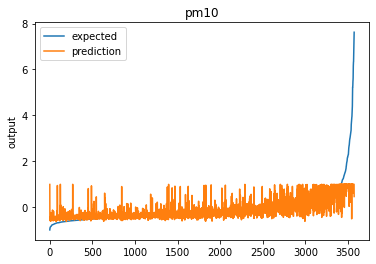

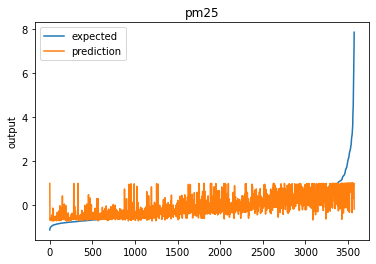

In [ ]:
#Regression Lift Chart
# Plot the chart
chart_regression(pred.flatten(),Y_seq_test, "pm10" ,sort=True)
print()
chart_regression(pred1.flatten(),Y_seq_test1, "pm25" ,sort=True)

# Using Bi-Directional LSTM

In [ ]:
df_updated_bi = df_updated_copy.copy()

In [ ]:
train_set_size = df_updated_bi.shape[0] * 0.70
train_set = Math.ceil(train_set_size)
df_train = df_updated_bi[0:train_set]
df_test = df_updated_bi[train_set+1 : df_updated_bi.shape[0]]

pm10_train = df_train['pm10'].tolist()
pm10_test = df_test['pm10'].tolist()

pm25_train = df_train['pm25'].tolist()
pm25_test = df_test['pm25'].tolist()

print("Training set pm10 has {} records.".format(len(pm10_train)))
print("Test set pm10 has {} records.".format(len(pm10_test)))

print("Training set pm25 has {} records.".format(len(pm10_train)))
print("Test set pm25 has {} records.".format(len(pm10_test)))

Training set pm10 has 8380 records.
Test set pm10 has 3590 records.
Training set pm25 has 8380 records.
Test set pm25 has 3590 records.


In [ ]:
SEQUENCE_SIZE = 15
X_seq_train, Y_seq_train = lstm_to_sequences(SEQUENCE_SIZE,pm10_train)
X_seq_test,Y_seq_test = lstm_to_sequences(SEQUENCE_SIZE,pm10_test)

X_seq_train1, Y_seq_train1 = lstm_to_sequences(SEQUENCE_SIZE,pm25_train)
X_seq_test1,Y_seq_test1 = lstm_to_sequences(SEQUENCE_SIZE,pm25_test)

print("Shape of X_seq_train: {}".format(X_seq_train.shape))
print("Shape of Y_seq_train: {}".format(Y_seq_train.shape))
print("Shape of X_seq_test: {}".format(X_seq_test.shape))
print("Shape of Y_seq_test: {}".format(Y_seq_test.shape))

Shape of X_seq_train: (8364, 15, 1)
Shape of Y_seq_train: (8364,)
Shape of X_seq_test: (3574, 15, 1)
Shape of Y_seq_test: (3574,)


In [ ]:
print('Build model...')
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(SEQUENCE_SIZE,1)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weight6.hdf5", verbose=0, save_best_only=True)


Build model...


In [ ]:
for i in range(3):
    model.fit(X_seq_train,Y_seq_train,validation_data=(X_seq_test,Y_seq_test), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('best_weight6.hdf5')

    #Predict
    pred = model.predict(X_seq_test)

for i in range(3):
    model.fit(X_seq_train1,Y_seq_train1,validation_data=(X_seq_test1,Y_seq_test1), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('best_weight6.hdf5')

    #Predict
    pred1 = model.predict(X_seq_test1)
    


Epoch 1/300
262/262 - 14s - loss: 0.5051 - val_loss: 0.1978
Epoch 2/300
262/262 - 6s - loss: 0.4171 - val_loss: 0.1734
Epoch 3/300
262/262 - 6s - loss: 0.4057 - val_loss: 0.2024
Epoch 4/300
262/262 - 6s - loss: 0.4095 - val_loss: 0.1818
Epoch 5/300
262/262 - 6s - loss: 0.3934 - val_loss: 0.1887
Epoch 6/300
262/262 - 6s - loss: 0.3881 - val_loss: 0.1822
Epoch 7/300
262/262 - 6s - loss: 0.3939 - val_loss: 0.1705
Epoch 8/300
262/262 - 6s - loss: 0.3936 - val_loss: 0.1717
Epoch 9/300
262/262 - 6s - loss: 0.3874 - val_loss: 0.1662
Epoch 10/300
262/262 - 6s - loss: 0.3846 - val_loss: 0.1743
Epoch 11/300
262/262 - 6s - loss: 0.3846 - val_loss: 0.1735
Epoch 12/300
262/262 - 6s - loss: 0.3766 - val_loss: 0.1708
Epoch 13/300
262/262 - 6s - loss: 0.3747 - val_loss: 0.1700
Epoch 14/300
262/262 - 6s - loss: 0.3781 - val_loss: 0.1685
Epoch 00014: early stopping
Epoch 1/300
262/262 - 6s - loss: 0.3855 - val_loss: 0.1704
Epoch 2/300
262/262 - 6s - loss: 0.3837 - val_loss: 0.1722
Epoch 3/300
262/262 - 

In [ ]:
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,Y_seq_test))
print("Score (RMSE) for pm10: {}".format(score))

score1 = np.sqrt(metrics.mean_squared_error(pred1,Y_seq_test1))
print("Score (RMSE) for pm25: {}".format(score1))

Score (RMSE) for pm10: 0.40131551640407026
Score (RMSE) for pm25: 0.4345430904054949


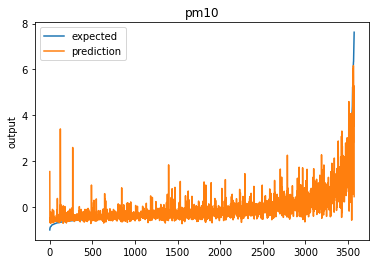

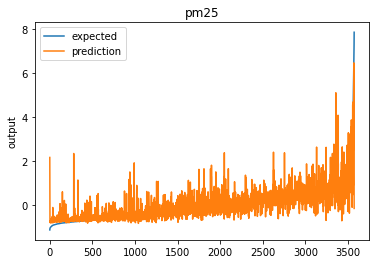

In [ ]:
#Regression Lift Chart
# Plot the chart
chart_regression(pred.flatten(),Y_seq_test, "pm10" ,sort=True)
print()
chart_regression(pred1.flatten(),Y_seq_test1, "pm25" ,sort=True)

# Using CNN Model



In [ ]:
df_updated_copy1 = df_updated_copy.copy()

In [ ]:

# Splitting data into 70% train and 30% test set for pm10
df_updated_copy1 = df_updated_copy1.drop(columns=['pm10'], axis=1)

train_set_size = df_updated_copy1.shape[0] * 0.70
train_set = Math.ceil(train_set_size)
df_train = df_updated_copy1[0:train_set]
df_test = df_updated_copy1[train_set+1 : df_updated_copy1.shape[0]]

close_train = df_train.values
close_test = df_test.values
train_unnormalise_close = df[0:train_set]
test_unnormalise_close = df[train_set+1 : df_updated_copy1.shape[0]]
train_unnormalise_close = train_unnormalise_close['pm10'].tolist()
test_unnormalise_close =test_unnormalise_close['pm10'].tolist()

df_updated_copy1 = df_updated_copy.copy()

# Splitting data into 70% train and 30% test set for pm25
df_updated_copy1 = df_updated_copy1.drop(columns=['pm25'], axis=1)

train_set_size = df_updated_copy1.shape[0] * 0.70
train_set = Math.ceil(train_set_size)
df_train1 = df_updated_copy1[0:train_set]
df_test1 = df_updated_copy1[train_set+1 : df_updated_copy1.shape[0]]

close_train1 = df_train1.values
close_test1 = df_test1.values
train_unnormalise_close1 = df[0:train_set]
test_unnormalise_close1 = df[train_set+1 : df_updated_copy1.shape[0]]
train_unnormalise_close1 = train_unnormalise_close1['pm25'].tolist()
test_unnormalise_close1 =test_unnormalise_close1['pm25'].tolist()



print("Training set has {} records.".format(len(close_train)))
print("Test set has {} records.".format(len(close_test)))

Training set has 8380 records.
Test set has 3590 records.


In [ ]:
SEQUENCE_SIZE = 7

x_train,y_train = cnn_to_sequences(SEQUENCE_SIZE,close_train,train_unnormalise_close)
x_test,y_test = cnn_to_sequences(SEQUENCE_SIZE,close_test,test_unnormalise_close)

x_train1,y_train1 = cnn_to_sequences(SEQUENCE_SIZE,close_train1,train_unnormalise_close1)
x_test1,y_test1 = cnn_to_sequences(SEQUENCE_SIZE,close_test1,test_unnormalise_close1)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

8372
3582
8372
3582
Shape of x_train: (8372, 1, 7, 133)
Shape of x_test: (3582, 1, 7, 133)
Shape of y_train: (8372,)
Shape of y_test: (3582,)


In [ ]:
print('Build model...')
model = Sequential()

model.add(Conv2D(200, kernel_size=(1, 4), strides=(1, 2),    # kernel size = (1,4)
                 activation='relu',
                 input_shape=(1,7,133)))    
model.add(Conv2D(167, (1,2), activation='relu'))
model.add(Dense(92, activation='relu'))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1))

Build model...


In [ ]:
from tensorflow.keras.optimizers import Adam


model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 2, 200)         106600    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 167)         66967     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1, 92)          15456     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 92)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 92)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 93        
Total params: 189,116
Trainable params: 189,116
Non-trainable params: 0
________________________________________________

In [ ]:
import time

start_time = time.time()

for p in range(2):
    model.fit(x_train, y_train,     
              epochs=300,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test, y_test))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    pred = model.predict(x_test)

for p in range(2):
    model.fit(x_train1, y_train1,     
              epochs=300,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test1, y_test1))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    pred1 = model.predict(x_test1)


Epoch 1/300
66/66 - 33s - loss: 973.1501 - accuracy: 0.0000e+00 - val_loss: 322.5182 - val_accuracy: 0.0000e+00
Epoch 2/300
66/66 - 0s - loss: 570.0309 - accuracy: 0.0000e+00 - val_loss: 320.2609 - val_accuracy: 0.0000e+00
Epoch 3/300
66/66 - 0s - loss: 542.6403 - accuracy: 0.0000e+00 - val_loss: 319.3556 - val_accuracy: 0.0000e+00
Epoch 4/300
66/66 - 0s - loss: 514.6180 - accuracy: 0.0000e+00 - val_loss: 372.3014 - val_accuracy: 0.0000e+00
Epoch 5/300
66/66 - 0s - loss: 482.2582 - accuracy: 0.0000e+00 - val_loss: 361.3585 - val_accuracy: 0.0000e+00
Epoch 6/300
66/66 - 0s - loss: 471.7804 - accuracy: 0.0000e+00 - val_loss: 384.4814 - val_accuracy: 0.0000e+00
Epoch 7/300
66/66 - 0s - loss: 450.6561 - accuracy: 0.0000e+00 - val_loss: 420.5946 - val_accuracy: 0.0000e+00
Epoch 8/300
66/66 - 0s - loss: 421.5076 - accuracy: 0.0000e+00 - val_loss: 478.3102 - val_accuracy: 0.0000e+00
Epoch 9/300
66/66 - 0s - loss: 422.0370 - accuracy: 0.0000e+00 - val_loss: 498.6895 - val_accuracy: 0.0000e+00


In [ ]:
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
score1 = np.sqrt(metrics.mean_squared_error(pred1,y_test1))
print("Score (RMSE): {}".format(score1))

Score (RMSE): 22.071025288755504
Score (RMSE): 11.34831388528678


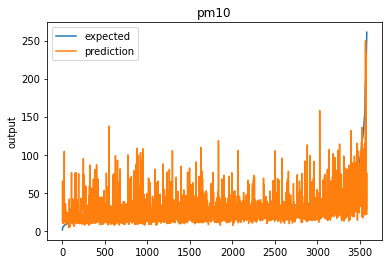

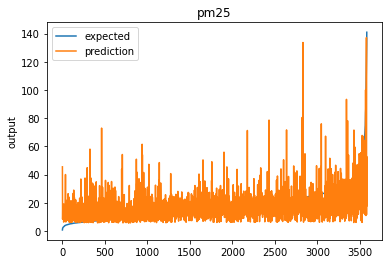

In [ ]:
#Regression Lift Chart

chart_regression(pred.flatten(),y_test, "pm10" ,sort=True)
print()
chart_regression(pred1.flatten(),y_test1, "pm25" ,sort=True)

# Hyper Tuning CNN 

In [ ]:
print('Build model...')
model = Sequential()

model.add(Conv2D(200, kernel_size=(1,3), strides=(1,1),    
                 activation='relu',
                 input_shape=(1,7,133)))    
model.add(Conv2D(167, (1,1), activation='relu'))
model.add(Dense(92, activation='relu'))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(1))

Build model...


In [ ]:
from tensorflow.keras.optimizers import Adam


model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 5, 200)         80000     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 5, 167)         33567     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 5, 92)          15456     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 5, 92)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 460)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 461       
Total params: 129,484
Trainable params: 129,484
Non-trainable params: 0
________________________________________________

In [ ]:
import time

start_time = time.time()

for p in range(2):
    model.fit(x_train, y_train,     
              epochs=300,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test, y_test))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    pred = model.predict(x_test)

for p in range(2):
    model.fit(x_train1, y_train1,     
              epochs=300,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test1, y_test1))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    pred1 = model.predict(x_test1)
    

Epoch 1/300
66/66 - 1s - loss: 931.2206 - accuracy: 0.0000e+00 - val_loss: 290.3604 - val_accuracy: 0.0000e+00
Epoch 2/300
66/66 - 0s - loss: 483.0955 - accuracy: 0.0000e+00 - val_loss: 267.1051 - val_accuracy: 0.0000e+00
Epoch 3/300
66/66 - 0s - loss: 449.7259 - accuracy: 0.0000e+00 - val_loss: 279.8588 - val_accuracy: 0.0000e+00
Epoch 4/300
66/66 - 0s - loss: 419.0774 - accuracy: 0.0000e+00 - val_loss: 271.4804 - val_accuracy: 0.0000e+00
Epoch 5/300
66/66 - 0s - loss: 384.4293 - accuracy: 0.0000e+00 - val_loss: 308.4048 - val_accuracy: 0.0000e+00
Epoch 6/300
66/66 - 0s - loss: 377.6607 - accuracy: 0.0000e+00 - val_loss: 348.2374 - val_accuracy: 0.0000e+00
Epoch 7/300
66/66 - 0s - loss: 359.9637 - accuracy: 0.0000e+00 - val_loss: 345.8065 - val_accuracy: 0.0000e+00
Epoch 8/300
66/66 - 0s - loss: 348.0744 - accuracy: 0.0000e+00 - val_loss: 426.9735 - val_accuracy: 0.0000e+00
Epoch 9/300
66/66 - 0s - loss: 343.3748 - accuracy: 0.0000e+00 - val_loss: 421.9018 - val_accuracy: 0.0000e+00
E

In [ ]:
# Measure RMSE error
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE) for pm10: {}".format(score))
score1 = np.sqrt(metrics.mean_squared_error(pred1,y_test1))
print("Score (RMSE) for pm25: {}".format(score1))

Score (RMSE) for pm10: 28.96843553938946
Score (RMSE) for pm25: 19.34646336081157


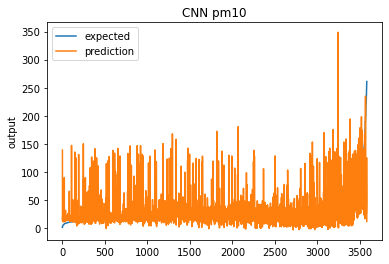

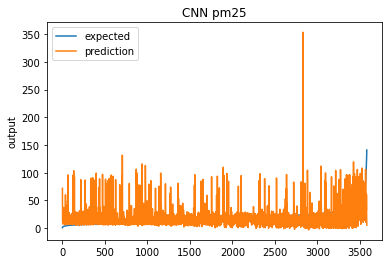

In [ ]:
#Regression Lift Chart

chart_regression(pred.flatten(),y_test,"CNN pm10" ,sort=True)
print()
chart_regression(pred1.flatten(),y_test1,"CNN pm25" ,sort=True)

# Using Functional API for multi-output regression

In [ ]:
df_updated_copy1 = df_updated_copy.copy()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 15, 100)      40800       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 50)           30200       lstm_3[0][0]                     
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 50)           30200       lstm_3[0][0]                     
____________________________________________________________________________________________

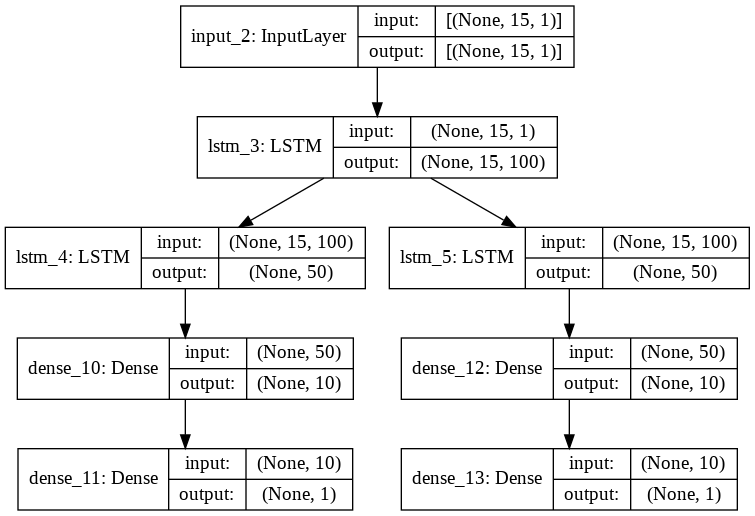

In [ ]:
# Multiple Outputs

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import LSTM


# input layer
visible = Input(shape=(15,1))


extract = LSTM(100, return_sequences=True)(visible)

# classification output
class11 = LSTM(50)(extract)
class12 = Dense(10, activation='relu')(class11)
output1 = Dense(1, activation='relu')(class12)


class21 = LSTM(50)(extract)
class22 = Dense(10, activation='relu')(class21)
output2 = Dense(1, activation='relu')(class22)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5", verbose=0, save_best_only=True)

# output
model = Model(inputs=visible, outputs=[output1, output2])

model.compile(loss="mean_squared_error", optimizer='adam')



# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/multiple_outputs.png', show_shapes=True)


In [ ]:
train_set_size = df_updated_copy1.shape[0] * 0.70
train_set = Math.ceil(train_set_size)
df_train = df_updated_copy1[0:train_set]
df_test = df_updated_copy1[train_set+1 : df_updated_copy1.shape[0]]

pm10_train = df_train['pm10'].tolist()
pm10_test = df_test['pm10'].tolist()

pm25_train = df_train['pm25'].tolist()
pm25_test = df_test['pm25'].tolist()

print("pm10 Training set has {} records.".format(len(pm10_train)))
print("pm10 Test set has {} records.".format(len(pm10_test)))

print("pm25 Training set has {} records.".format(len(pm25_train)))
print("pm25 Test set has {} records.".format(len(pm25_test)))

pm10 Training set has 8380 records.
pm10 Test set has 3590 records.
pm25 Training set has 8380 records.
pm25 Test set has 3590 records.


In [ ]:
SEQUENCE_SIZE = 15
X_seq_train1, Y_seq_train1 = lstm_to_sequences(SEQUENCE_SIZE,pm10_train)
X_seq_train2, Y_seq_train2 = lstm_to_sequences(SEQUENCE_SIZE,pm25_train)

X_seq_test1,Y_seq_test1 = lstm_to_sequences(SEQUENCE_SIZE,pm10_test)
X_seq_test2,Y_seq_test2 = lstm_to_sequences(SEQUENCE_SIZE,pm25_test)

print("Shape of X_seq_train1: {}".format(X_seq_train1.shape))
print("Shape of Y_seq_train1: {}".format(Y_seq_train1.shape))
print("Shape of X_seq_test1: {}".format(X_seq_test1.shape))
print("Shape of Y_seq_test1: {}".format(Y_seq_test1.shape))

print("Shape of X_seq_train2: {}".format(X_seq_train2.shape))
print("Shape of Y_seq_train2: {}".format(Y_seq_train2.shape))
print("Shape of X_seq_test2: {}".format(X_seq_test2.shape))
print("Shape of Y_seq_test2: {}".format(Y_seq_test2.shape))


Shape of X_seq_train1: (8364, 15, 1)
Shape of Y_seq_train1: (8364,)
Shape of X_seq_test1: (3574, 15, 1)
Shape of Y_seq_test1: (3574,)
Shape of X_seq_train2: (8364, 15, 1)
Shape of Y_seq_train2: (8364,)
Shape of X_seq_test2: (3574, 15, 1)
Shape of Y_seq_test2: (3574,)


In [ ]:
for i in range(3):
    model.fit(X_seq_train1,[Y_seq_train1,Y_seq_train2],validation_data=(X_seq_test1, [Y_seq_test1,Y_seq_test2]), callbacks=[monitor,checkpointer],verbose=2, epochs=300)    
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5')

    #Predict
    pred = model.predict(X_seq_test1)


Epoch 1/300
262/262 - 7s - loss: 1.2299 - dense_11_loss: 0.6018 - dense_13_loss: 0.6280 - val_loss: 0.6659 - val_dense_11_loss: 0.2983 - val_dense_13_loss: 0.3675
Epoch 2/300
262/262 - 2s - loss: 1.1064 - dense_11_loss: 0.5350 - dense_13_loss: 0.5714 - val_loss: 0.6225 - val_dense_11_loss: 0.2504 - val_dense_13_loss: 0.3721
Epoch 3/300
262/262 - 2s - loss: 1.0934 - dense_11_loss: 0.5289 - dense_13_loss: 0.5645 - val_loss: 0.6311 - val_dense_11_loss: 0.2684 - val_dense_13_loss: 0.3627
Epoch 4/300
262/262 - 2s - loss: 1.0684 - dense_11_loss: 0.5166 - dense_13_loss: 0.5518 - val_loss: 0.6345 - val_dense_11_loss: 0.2529 - val_dense_13_loss: 0.3815
Epoch 5/300
262/262 - 2s - loss: 1.0683 - dense_11_loss: 0.5177 - dense_13_loss: 0.5507 - val_loss: 0.6519 - val_dense_11_loss: 0.2599 - val_dense_13_loss: 0.3921
Epoch 6/300
262/262 - 2s - loss: 1.0545 - dense_11_loss: 0.5081 - dense_13_loss: 0.5465 - val_loss: 0.6327 - val_dense_11_loss: 0.2644 - val_dense_13_loss: 0.3683
Epoch 7/300
262/262 - 

In [ ]:
#  Measure RMSE error pm10.
score = np.sqrt(metrics.mean_squared_error(pred[0],Y_seq_test1))
print("Score (RMSE) for pm10: {}".format(score))

#  Measure RMSE error pm2.5
score = np.sqrt(metrics.mean_squared_error(pred[1],Y_seq_test2))
print("Score (RMSE) for pm25: {}".format(score))

Score (RMSE) for pm10: 0.4975313365852797
Score (RMSE) for pm25: 0.584273768550343


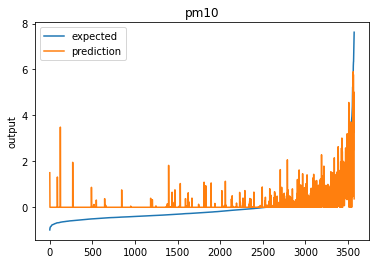

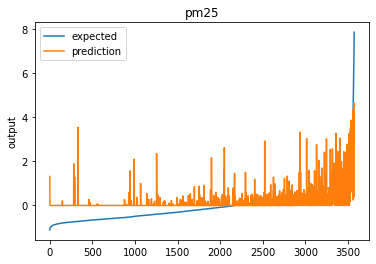

In [ ]:
#Regression Lift Chart
# Plot the chart for pm10
chart_regression(pred[0].flatten(),Y_seq_test1, "pm10" ,sort=True)

print()

# Plot the chart for pm25
chart_regression(pred[1].flatten(),Y_seq_test2, "pm25" ,sort=True)